# Jesse Moore
# Phase 3 Project - Customer Churn 
# Instructor Mark
# blog post: https://medium.com/@jessecmoore222/clarifying-confusion-tables-0918c091f337

# Predictive Modeling for Customer Churn for Telephone Company

<img src='images/pk-1.png' alt='Customer Churn' width='1000'>

# Overview

### SyriaTel wishes to understand more about why customers cancel their service ('churn') to help them develop a more effective retention strategy. In this report, I have analyzed their data using predictive modeling techniques to develop insight into their customer churn. 

In [1]:
#Importing the standard libraries using the standard aliasing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import make_column_selector as selector

from xgboost import XGBRFClassifier, XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # To handle SMOTE inside pipeline
from imblearn.over_sampling import SMOTE
import warnings


%matplotlib inline

In [2]:
# Here we will look at some 'quality of life' adjustments that will improve the readability and aesthetics of our notebook and visualizations.
crayon_pal = sns.crayon_palette(["Wild Watermelon","Wisteria","Wild Strawberry"])
#setting some style for seaborn for our plots. 
sns.set_theme(style='whitegrid', palette=crayon_pal)
#ignoring warnings 
warnings.filterwarnings("ignore")
#Setting our pandas options so that we can view all of the columns of our dataset later
pd.set_option('display.max_columns', None)

# Business Understanding

## Problem Statement

### Customer retention, or 'Churn', is a critical challenge for our client, as high churn rates lead to significant revenue loss. As attracting a new customer costs [5 to 7 times more than keeping an existing customer](https://www.forbes.com/councils/forbesbusinesscouncil/2022/12/12/customer-retention-versus-customer-acquisition/).  We lack a reliable method to predict which customers are likely to leave and why. 

## Stakeholder Questions

### What features play the largest role in determing whether a customer will churn?
### What is the percentage of customers who churn?
### What states or area codes have the highest churn?
### What role do features such as voice mail, international plans/calls, and customer service calls play in our churn?

## Business Objective

### We lack a reliable method to predict which customers are likely to leave and why. The goal of this analysis is to develop a machine learning model that can accurately identify at-risk customers based on historical data, allowing the company to take proactive measures to improve retention. By optimizing for recall, we aim to minimize false negatives and ensure that as many churn-prone customers as possible are correctly identified.

# A false negative (Type II error) occurs when the model incorrectly predicts that a customer will stay, but in reality, they churn. In other words, the model fails to identify an at-risk customer. The False Negative Rate (FNR) is calculated as:

False Negative Rate
=
False Negatives
Actual Positives
False Negative Rate= 
Actual Positives
False Negatives
​	
 
For our churn model, minimizing false negatives is crucial because failing to identify a churn-prone customer means losing an opportunity to intervene and retain them.

To visualize this, we will use a confusion matrix, which provides a breakdown of the model’s predictions:

Top-left (True Positives - TP): Correctly identified churned customers.
Top-right (False Positives - FP): Customers incorrectly predicted to churn when they actually stayed.
Bottom-left (False Negatives - FN): Customers incorrectly predicted to stay when they actually churned.
Bottom-right (True Negatives - TN): Correctly identified retained customers.
By examining the confusion matrix, we can assess the trade-offs between precision and recall, ensuring that our model prioritizes correctly identifying at-risk customers.

# Data Understanding

## Data Source

### Our dataset, Syria Tel's own internally collected data, which is located here: [ 'Churn in Telecom's Dataset](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset), has been saved locally as 'cust_churn.csv'.

In [3]:
#Loading in our dataset
df = pd.read_csv('data/cust_churn.csv')

## Data Description

### The dataset contains 3333 records on customer's State, account length, area code and phone number, if they have international and / or voicemail plans, if so, the number of voicemail messages they have recieved as vmail messages, and for the categories of daytime calls, evening calls, nighttime calls, and international calls, we are given the total number of minutes, total number of calls, the total amounts charged, how many customer service calls the customer made and whether they ultimately churned or not. 

In [4]:
#general info
df.info()

#We can see that the dataset has 3333 entries of 21 columns with 0 null values. 
#The majority of data types are numeric, with 'state', 'phone number', 'international plan', and 'voice mail plan' being categorical.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
#analyzing the shape and nulls
print(f'The DataFrame is {df.shape[1]} columns with {df.shape[0]} rows, and has {(df.isna().sum()).sum()} null values')

The DataFrame is 21 columns with 3333 rows, and has 0 null values


In [6]:
#Initial viewing of data.

#Observing the data we can see that we will need to deal with several columns in our data cleaning stage. 

#Numeric values will need to be scaled as they widely vary. 
#'state' - we will need to OneHotEncode this column and drop the original later as it is a categorical variable with more than 2 possible values.
#'international plan', 'voice mail plan' and 'churn' - we will map to values of 0 or 1. 
#'phone number' - we will drop this column as every value is, or should be unique. 

df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
#A short look at the descriptive statistics.
print(df.describe())

       account length    area code  number vmail messages  total day minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total day calls  total day charge  total eve minutes  total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.25943

In [8]:
# Drop irrelevant columns
# df.drop(columns=['phone number', 'state'], inplace=True, errors='ignore', axis=1)
df.drop(columns=['phone number'], inplace=True, errors='ignore', axis=1)

#'phone number' is an irrelevant column because every value for it will be unique, we will learn nothing from including it in our dataset and
#we would have to OneHotEncode 3333 different values!

In [9]:
#The next step is to engineer two features that we will review in our analasis: 'total calls' and 'total minutes. 


total_calls_columns = [
    'total day calls',
    'total eve calls',
    'total night calls',
    'total intl calls'
]

total_minutes_columns = [
    'total day minutes',
    'total eve minutes',
    'total night minutes',
    'total intl minutes'
]

total_charges_columns = [
    'total day charge',
    'total eve charge',
    'total night charge',
    'total intl charge'
]


def calculate_totals(df):
    # Sum up the specified columns
    df['total calls'] = df[total_calls_columns].sum(axis=1)
    df['total minutes'] = df[total_minutes_columns].sum(axis=1)
    df['total charges'] = df[total_charges_columns].sum(axis=1)

In [10]:
#running our function to create our features
df_with_totals = calculate_totals(df)

In [11]:
df = pd.concat([df, df_with_totals], axis=1)

In [12]:
#let's create a function that will enable us to create histograms quickly in order to view the distribution of our dataset.

def histogram_plotter(df, bins=30, color='steelblue'):
    num_cols = df.columns 
    num_features = len(num_cols)
    
    # Determine subplot grid size
    cols_per_row = 4
    num_rows = (num_features + cols_per_row - 1) // cols_per_row  
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(16, 4 * num_rows))
    axes = axes.flatten()  

    sns.set_palette("pastel")
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=bins, kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")

    plt.tight_layout();

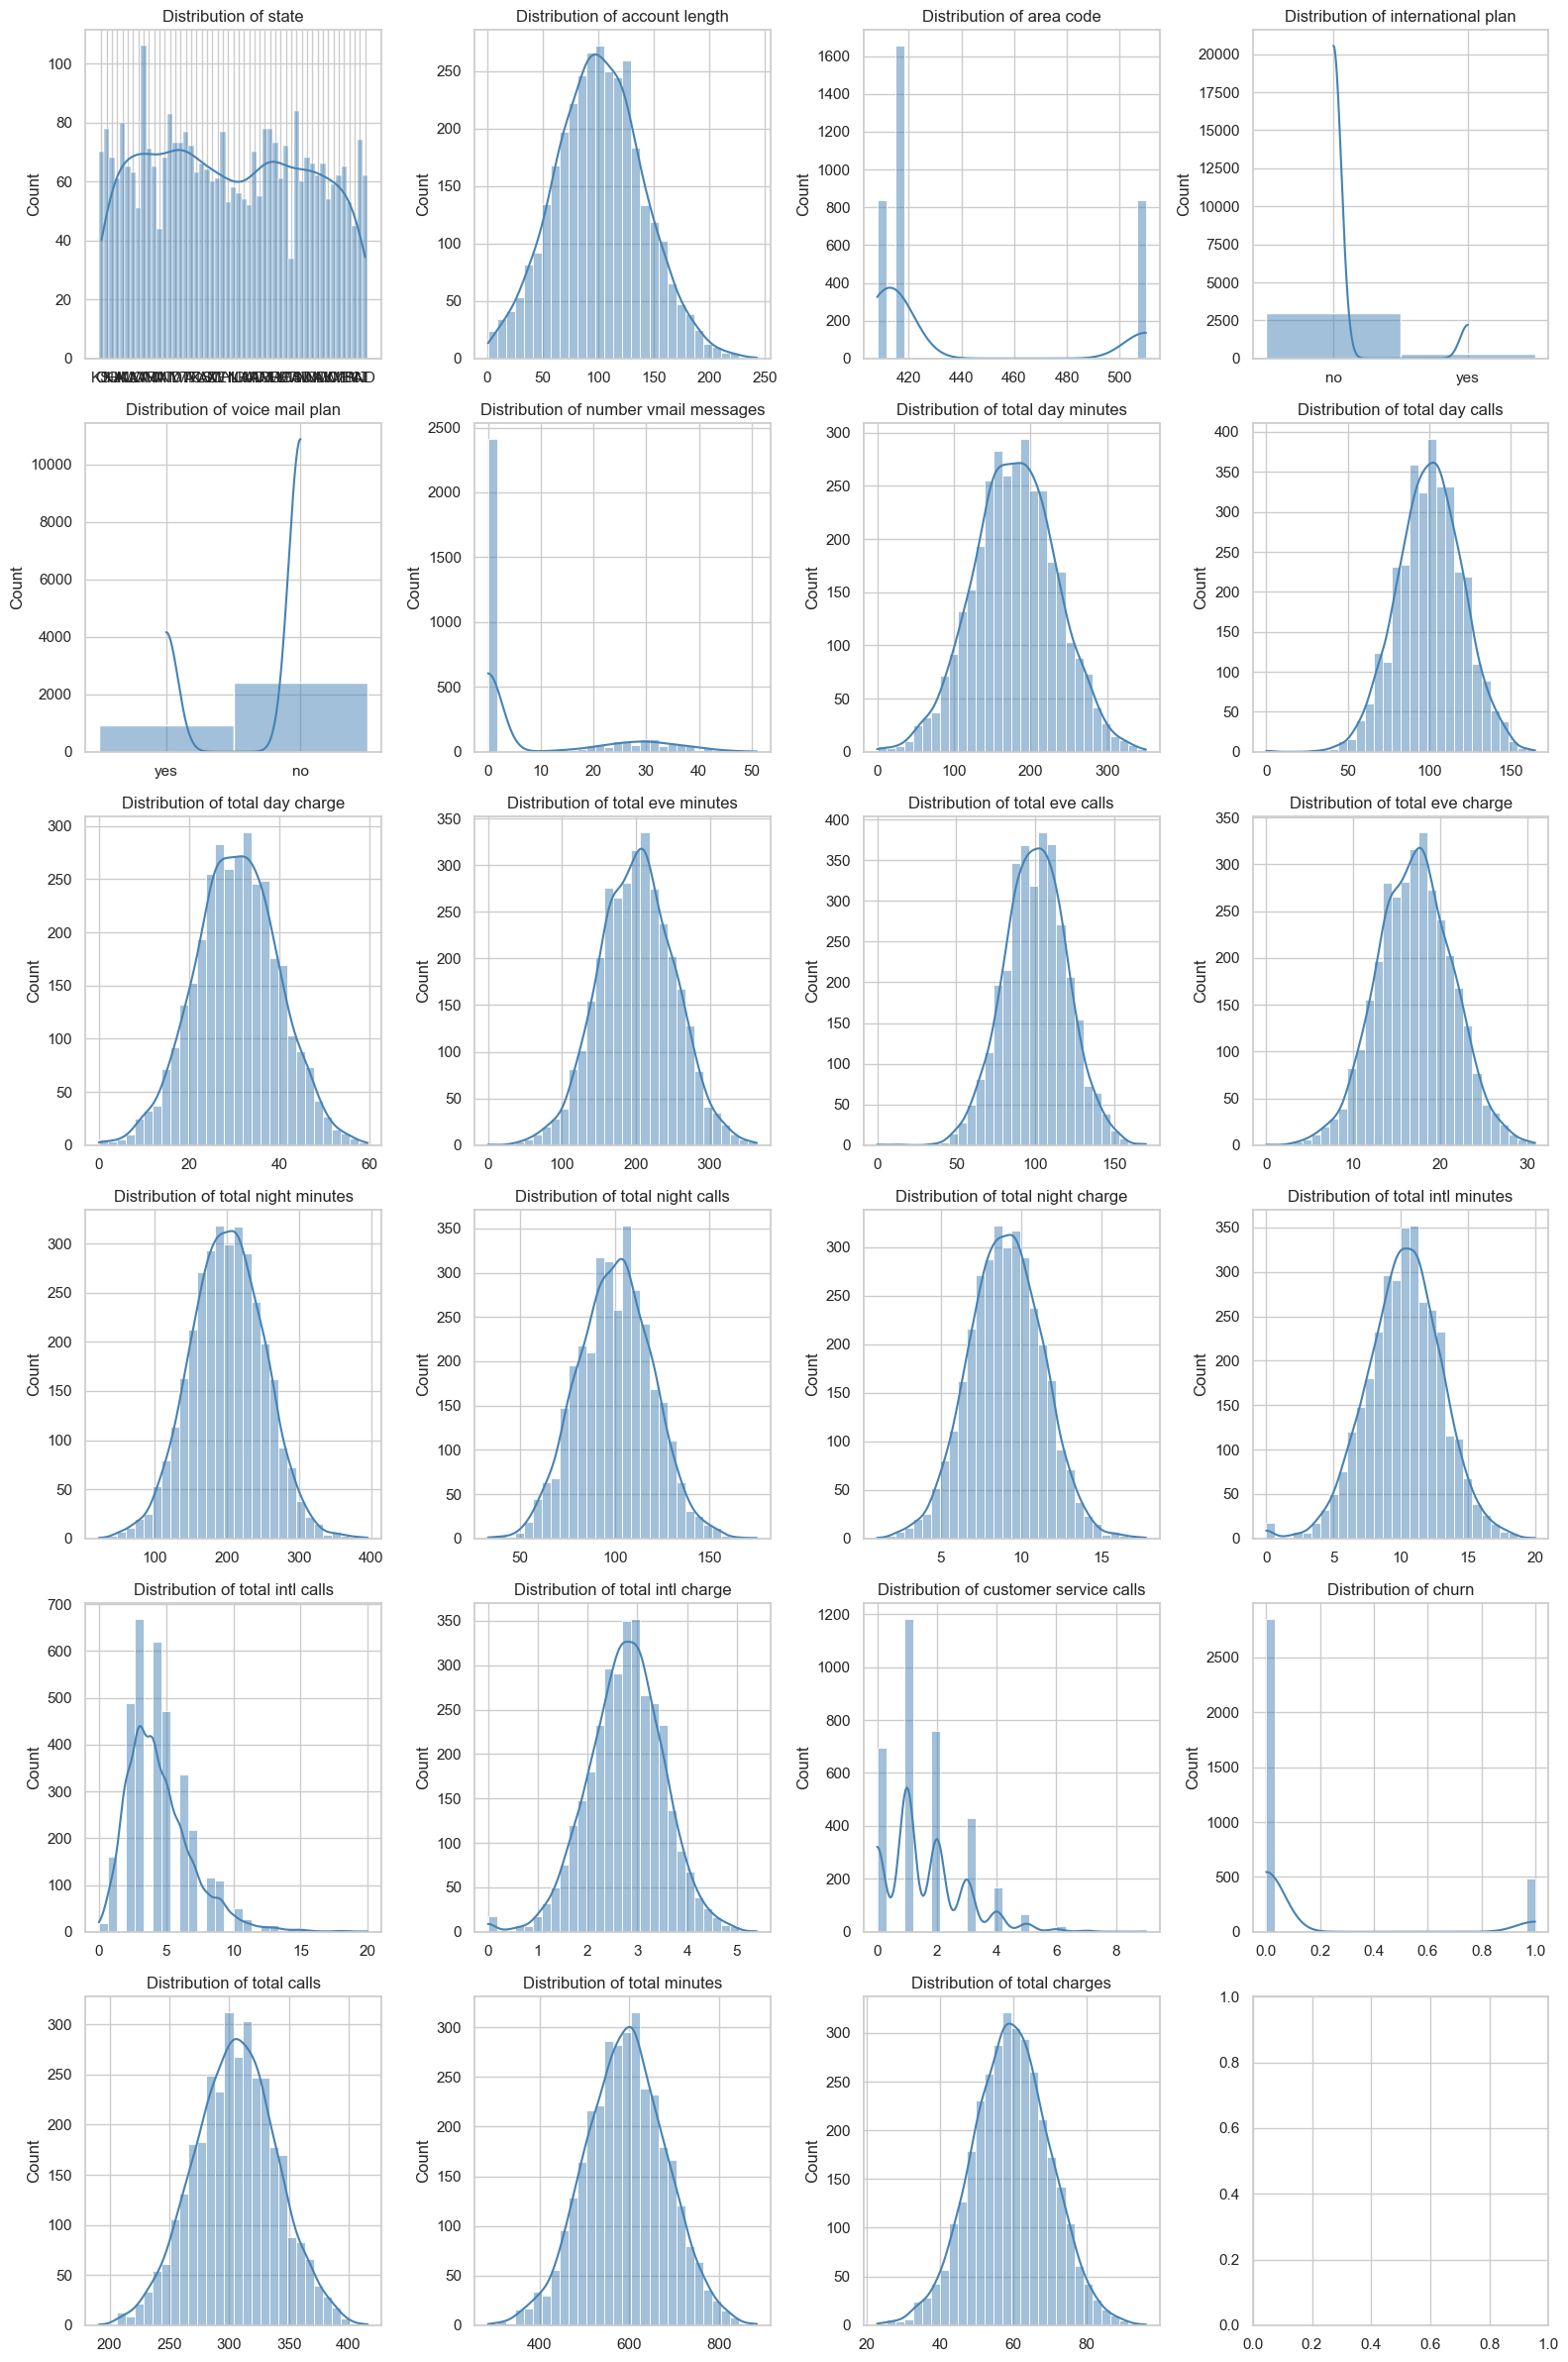

In [13]:
#calling our histogram function
histogram_plotter(df)

In [14]:
#Now let's analyze the actual percentage of customers who churned.
churn_counts = df['churn'].value_counts()
churn_percent = float(df['churn'].value_counts(normalize=True)[1] * 100)
print(f'Not Churned: {churn_counts[0]}\nChurned: {churn_counts[1]} \nChurn Percent: {churn_percent:.2f}%')

#Our dataset is highly imbalanced, however we can make the case against using techniques such as SMOTE as they can lend to overfitting.
#As a remedy to the imbalance, we will try setting class weights where applicable. 

Not Churned: 2850
Churned: 483 
Churn Percent: 14.49%


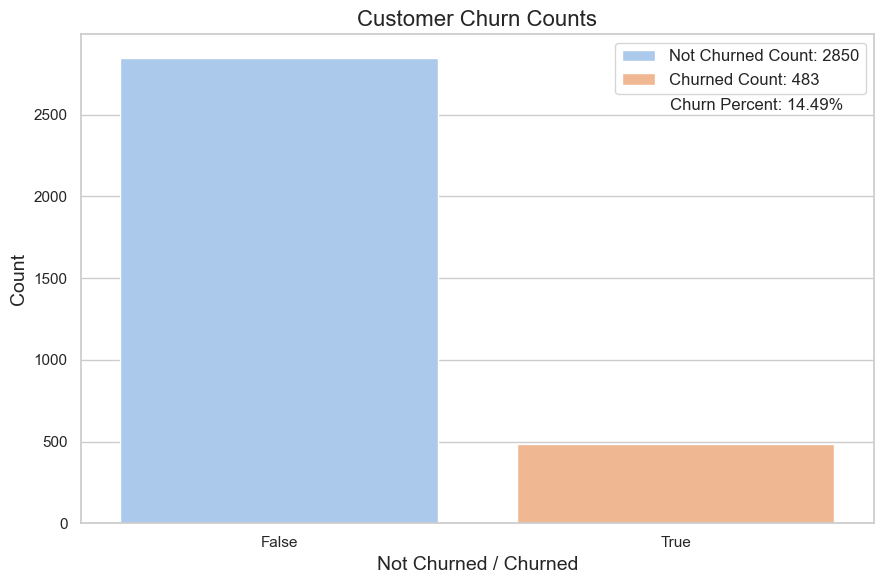

In [15]:
#Plotting the churn percent
# Create the plot
plt.figure(figsize=(9,6))
sns.countplot(x=df['churn'], hue=df['churn'])
plt.legend(labels=[f'Not Churned Count: {churn_counts[0]}', f'Churned Count: {churn_counts[1]}'], fontsize='medium' )
plt.text(x=0.985, y=2529, s=f'Churn Percent: {churn_percent:.2f}%', fontsize='medium')


# Adding labels to the axes
plt.xlabel('Not Churned / Churned', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adding a title
plt.title("Customer Churn Counts", fontsize=16)

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

# Save the plot as a PNG image and using ';' to show the plot. 
plt.savefig('images/churn_counts.png', bbox_inches='tight', pad_inches= 0.2);

In [16]:
#Mapping our categorical values (aside from 'state') as 0's and 1's. 

#creating a list of 'yes/no' categorical variables.
categories_to_map = ['international plan', 'voice mail plan']

#mapping our categories using .map
for cat in categories_to_map:
        df[cat]=df[cat].map({"no":0,"yes":1})

#Mapping our target, 'churn'. 
df['churn']= df['churn'].map({False:0, True:1})

In [17]:
#copying our dataset to protect our original data before we start to transform it. 
copy_df = df.copy()

In [18]:
#let us start with a simple model based upon just one feature and then we will scale it up. 

In [19]:
# train_df = pd.concat([X_train, y_train], axis=1)

In [20]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=object)),
        ("cat", categorical_transformer, selector(dtype_include=object)),
    ], sparse_threshold=0.0
)

In [21]:
best_model = None
best_recall_score = 0
results = {}
best_is_new = False

In [22]:
param_grid = {
    "K-Neighbors": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    },
    "Decision Tree": {
        "model__max_depth": [3, 5, 10, 20, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    },
    "Random Forest": {
        "model__n_estimators": [50, 100, 200, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]},
    
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100, 1000],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__solver": ["liblinear", "saga"]}
}

In [23]:

# # Define features and target variable
X = copy_df.drop(columns='churn', axis=1)
y = copy_df['churn']
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold_out, y_hold_out, test_size=0.5, random_state=42, stratify=y_hold_out)

## Step 1: Fit the preprocessor ONLY on the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Step 2: Transform the validation and test sets using the **already fitted** preprocessor
X_valid_transformed = preprocessor.transform(X_valid)
X_test_transformed = preprocessor.transform(X_test)

# Step 3: Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Step 4: Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)

    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
    Validation Accuracy: 0.940 | Precision: 0.766 | Recall: 0.845 | F1-Score: 0.804


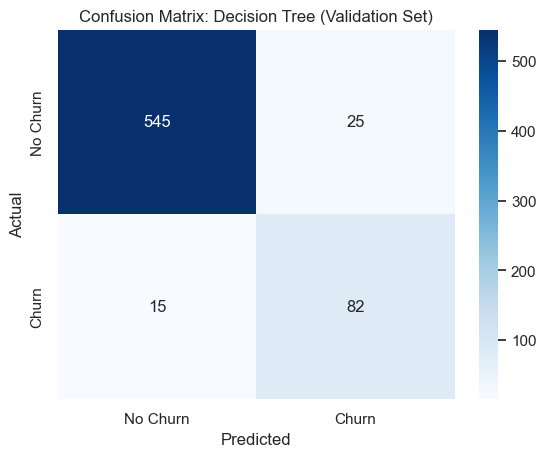

In [24]:
# Define the model
model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {model_name} (Validation Set)")
plt.show()

    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
    Validation Accuracy: 0.940 | Precision: 0.766 | Recall: 0.845 | F1-Score: 0.804


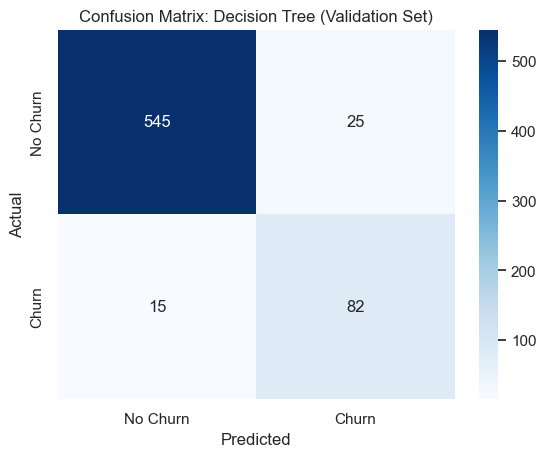

In [41]:
# Define the model
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {model_name} (Validation Set)")
plt.show()

    Test Set Final Evaluation:
    Accuracy: 0.922 | Precision: 0.700 | Recall: 0.802 | F1-Score: 0.748


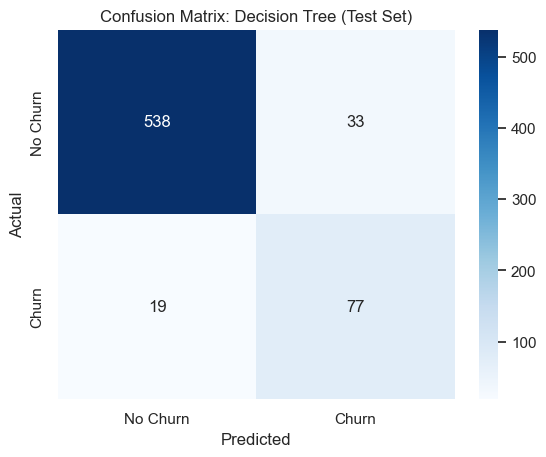

In [42]:
# === Evaluate the Final Model on the Hold-Out (Test) Set ===
y_test_pred = pipeline.predict(X_test_transformed)

# Calculate evaluation metrics on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"    Test Set Final Evaluation:")
print(f"    Accuracy: {test_accuracy:.3f} | Precision: {test_precision:.3f} | Recall: {test_recall:.3f} | F1-Score: {test_f1:.3f}")

# Plot confusion matrix for the hold-out test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {model_name} (Test Set)")
plt.show()

In [27]:
def model_train_and_eval(models_dict, param_grid, X_train, y_train, X_test, y_test, best_model, best_recall_score, transformed_X_train):
    """
    Trains and evaluates multiple models using cross-validation and grid search for hyperparameter tuning.

    Parameters:
    - models_dict: A dictionary of model names and instances.
    - X_train, X_test: Preprocessed feature sets after train-test split.
    - y_train, y_test: Target labels after train-test split.

    Returns:
    - results: A dictionary with evaluation metrics for all models.
    """

    results = {}
    best_is_new = False

    
    for model_name, model in models_dict.items():
        print(f"\nTraining {model_name}")

        # Create a pipeline
        pipeline = Pipeline([
            ('model', model)
        ])

        # Apply GridSearchCV if the model has hyperparameters to tune
        if model_name in param_grid:
            grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
            best_params = grid_search.best_params_
            print(f"    Best Parameters: {best_params}")
        else:
            # Perform cross-validation without GridSearchCV
            cv_results = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
            mean_cv_score = np.mean(cv_results['test_score'])
            std_cv_score = np.std(cv_results['test_score'])
            print(f"    Cross-Validation Score: {mean_cv_score:.3f} ± {std_cv_score:.3f}")

            # Fit on the full training set
            pipeline.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"    Test Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1-Score: {f1:.3f}")

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {model_name}")
        plt.show()

      

        results[model_name] = {
            'best_params': best_params if model_name in param_grid else "N/A",
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1_score': f1
        }

        if recall > best_recall_score:
            best_recall_score = recall
            best_model = pipeline
            best_is_new = True
            #so now change the print statement to pdate with new modell...and change zarvox 
    
    transformed_X_train = transformed_X_train 
    
    return results, best_model, transformed_X_train



In [28]:
def new_function(columns_list, df_to_use, models_to_test, param_grid, preprocessor):
    
    simple_df = df_to_use[columns_list]
    # # Define features and target variable
    X = simple_df.drop(columns='churn')
    y = simple_df['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply transformations
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    X_hold_out_transformed = preprocessor.transform(X_hold_out)

    transformed_X_train = X_train_transformed
    # Convert transformed array back to DataFrame with the original index
    transformed_feature_names = preprocessor.get_feature_names_out()
    
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)
    # Convert transformed hold-out data to DataFrame (same as done for training data)
    X_hold_out_transformed = pd.DataFrame(X_hold_out_transformed, columns=transformed_feature_names, index=X_hold_out.index)


    results, best_model, transformed_X_train = model_train_and_eval(models_to_test, param_grid, X_train_transformed, y_train, X_test_transformed, y_test, None, 0, transformed_X_train)
    
    return results, best_model, transformed_X_train, X_hold_out_transformed



In [29]:
train_df = df.copy()

In [30]:
# best_model = None
# best_recall_score = 0

## Our First Model - Decision Tree

In [31]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

In [32]:
#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
first_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
}

In [33]:
#The metrics to search in our grid search.
first_model_param_grid = {
     "Decision Tree": {
        "model__max_depth": [3, 5, 10, 20, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    }
}


Training Decision Tree
    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
    Test Accuracy: 0.793 | Precision: 0.127 | Recall: 0.072 | F1-Score: 0.092


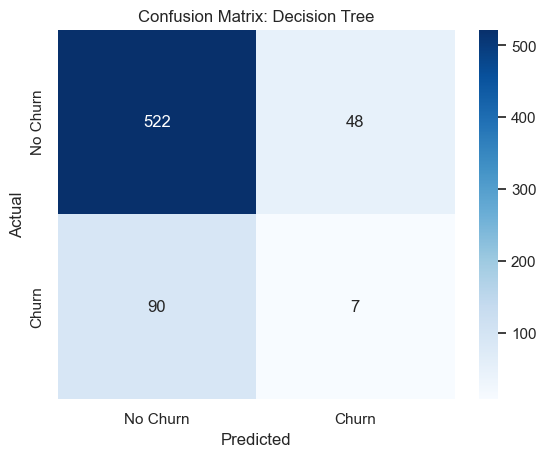

In [34]:
first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)
#produces a recall score of 0.429


Training Decision Tree
    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
    Test Accuracy: 0.651 | Precision: 0.214 | Recall: 0.526 | F1-Score: 0.304


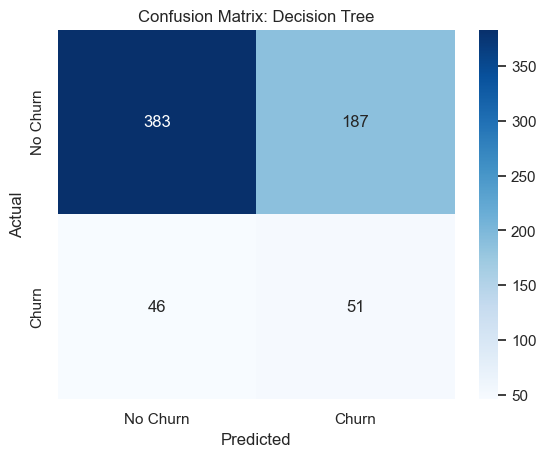

In [35]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42, class_weight='balanced')
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Decision Tree
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
    Test Accuracy: 0.871 | Precision: 0.565 | Recall: 0.495 | F1-Score: 0.527


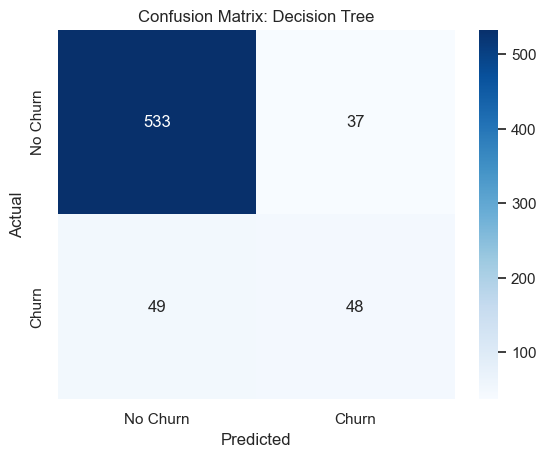

In [36]:
#let's add another feature, and continue to tweak the hyperparameters changing min_samples_leaf=5... 

third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42, class_weight='balanced', min_samples_leaf=5)
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Decision Tree
    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
    Test Accuracy: 0.810 | Precision: 0.406 | Recall: 0.670 | F1-Score: 0.506


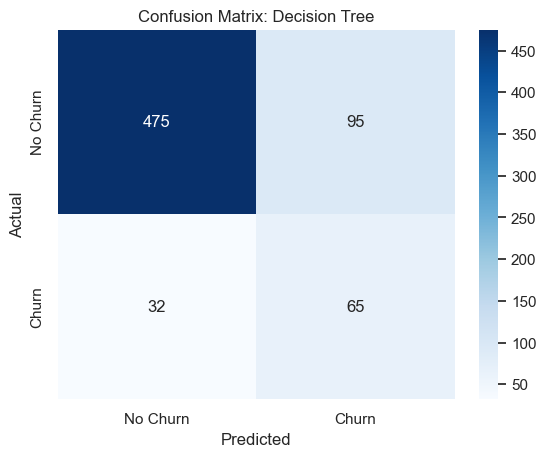

In [37]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Decision Tree
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
    Test Accuracy: 0.900 | Precision: 0.612 | Recall: 0.845 | F1-Score: 0.710


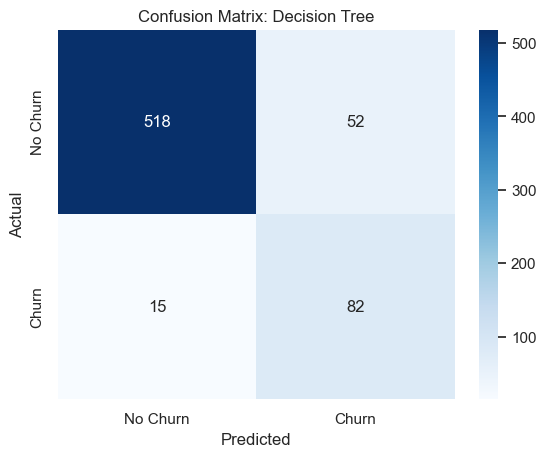

In [38]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced', min_samples_leaf=2, min_samples_split=2)}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Decision Tree
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
    Test Accuracy: 0.900 | Precision: 0.612 | Recall: 0.845 | F1-Score: 0.710


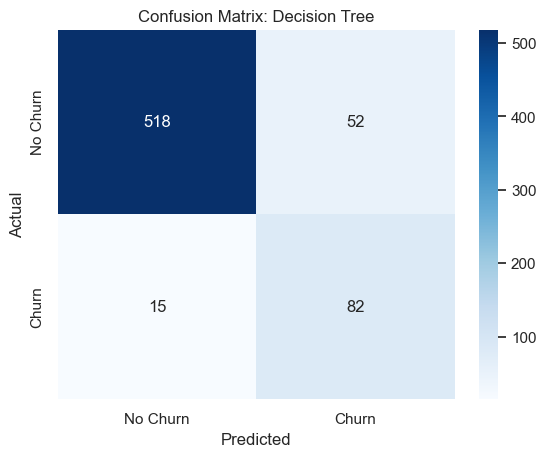

In [39]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced', min_samples_leaf=2, min_samples_split=2)}
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

## With a Recall of .896 this is a very good recall score for our 'churn' data!

## Second Model - Random Forest


Training Random Forest
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
    Test Accuracy: 0.634 | Precision: 0.161 | Recall: 0.361 | F1-Score: 0.223


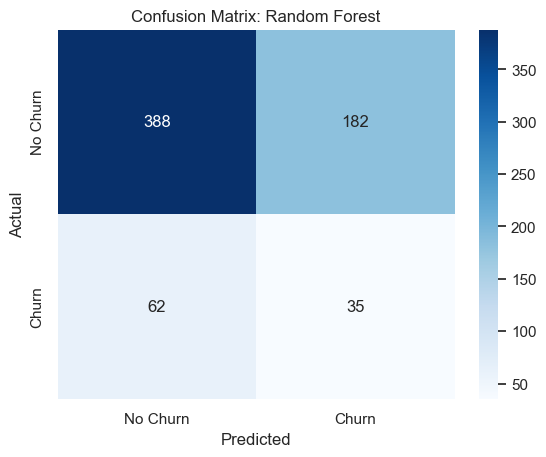

In [40]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Starting with Random Forest and setting class_weight='balanced' to help us with our class imbalance issues.
first_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced',  random_state=42),
}

#The metrics to search in our grid search.
first_model_param_grid = {
      "Random Forest": {
        "model__n_estimators": [50, 100, 200, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]}
}

first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)
#produces a recall score of .429


Training Random Forest
    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}
    Test Accuracy: 0.804 | Precision: 0.353 | Recall: 0.423 | F1-Score: 0.385


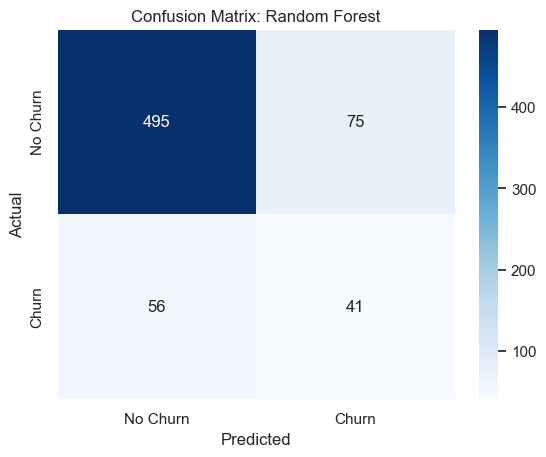

In [41]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls', 'total minutes', 'churn']

#Let's adjust our min_samples_leaf=5
second_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', min_samples_leaf=5, random_state=42),
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Random Forest
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}
    Test Accuracy: 0.874 | Precision: 0.575 | Recall: 0.515 | F1-Score: 0.543


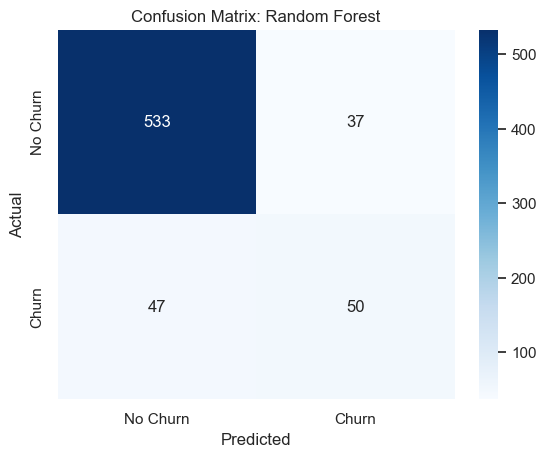

In [42]:
#Hmm our recall actually went down when we added 'total minutes'.

#Now let's add in one feature more feature, 'total minutes'.
third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#
third_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', min_samples_leaf=5, random_state=42),
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Random Forest
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
    Test Accuracy: 0.918 | Precision: 0.744 | Recall: 0.660 | F1-Score: 0.699


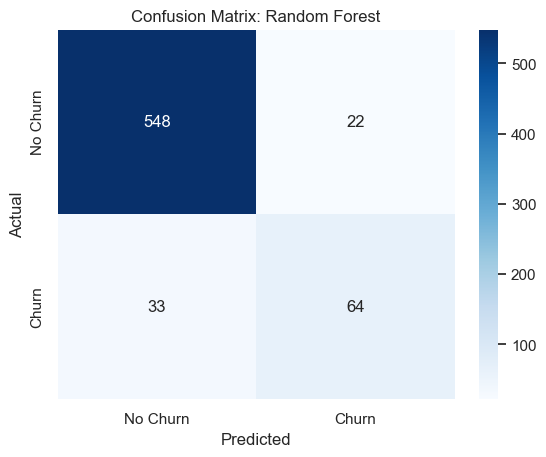

In [43]:
#let's add another feature, 'customer service calls', and  remove our 'total minutes' feature, 


fourth_model_columns = ['total calls', 'total charges', 'customer service calls', 'churn']

#
fourth_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Random Forest
    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
    Test Accuracy: 0.901 | Precision: 0.618 | Recall: 0.835 | F1-Score: 0.711


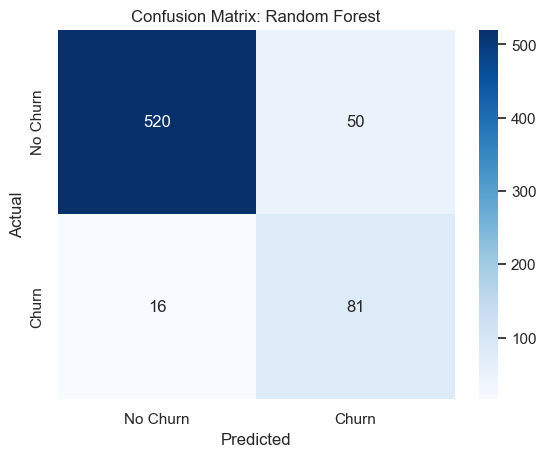

In [44]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls', 'total charges', 'customer service calls', 'international plan', 'churn']

#
fifth_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor)


Training Random Forest
    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
    Test Accuracy: 0.864 | Precision: 0.519 | Recall: 0.845 | F1-Score: 0.643


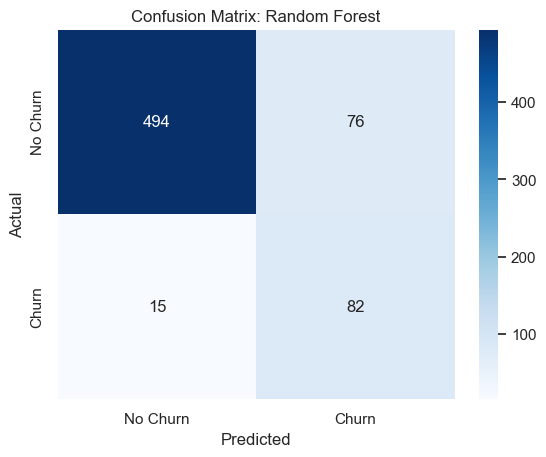

In [45]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)}
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

In [2]:
#let's add our 'total minutes' feature back in to see what it does to our recall. 

seventh_model_columns = ['state', 'total calls', 'total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
seventh_model_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)}
seventh_model_results = new_function(seventh_model_columns, train_df, seventh_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

NameError: name 'RandomForestClassifier' is not defined

## This last one was *slightly* better than the results before, and we haven't tweaked any hyperparameters yet with it, so maybe that would help.

# Logistic Regression


Training Logistic Regression
    Best Parameters: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    Test Accuracy: 0.478 | Precision: 0.146 | Recall: 0.536 | F1-Score: 0.230


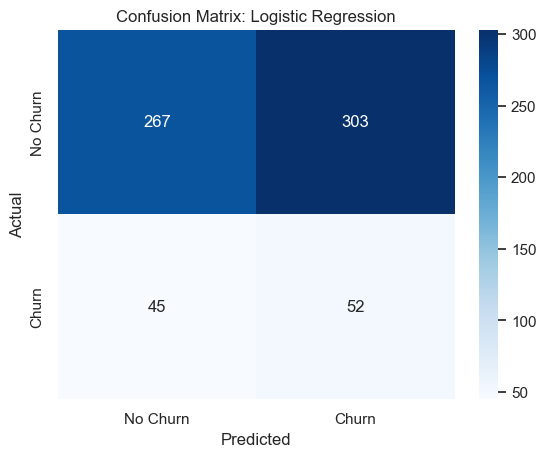

In [47]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Logistic Regression
first_model_to_test = {
    "Logistic Regression": LogisticRegression(C=1e3, max_iter=10000, class_weight='balanced', random_state=42)
}


#The metrics to search in our grid search.
first_model_param_grid = {
  "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100, 1000],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__solver": ["liblinear", "saga"]}
}

first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)
#produces a recall score of 0.429


Training Logistic Regression
    Best Parameters: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    Test Accuracy: 0.531 | Precision: 0.190 | Recall: 0.680 | F1-Score: 0.297


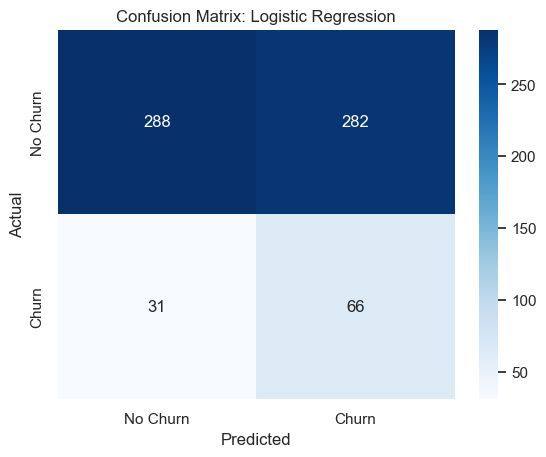

In [48]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "Logistic Regression": LogisticRegression(C=0.01, max_iter=10000, class_weight='balanced', random_state=42)
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor)


Training Logistic Regression
    Best Parameters: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    Test Accuracy: 0.522 | Precision: 0.183 | Recall: 0.660 | F1-Score: 0.286


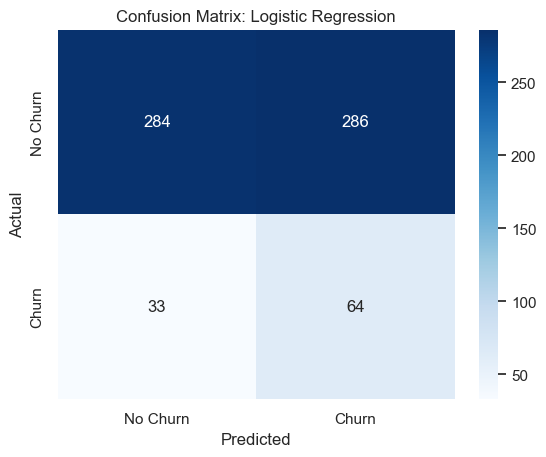

In [49]:
#let's add another feature, and continue to tweak the hyperparameters changing min_samples_leaf=5... 

third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "Logistic Regression": LogisticRegression(C=100, max_iter=100000, class_weight='balanced', random_state=42)
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Logistic Regression
    Best Parameters: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    Test Accuracy: 0.607 | Precision: 0.243 | Recall: 0.804 | F1-Score: 0.373


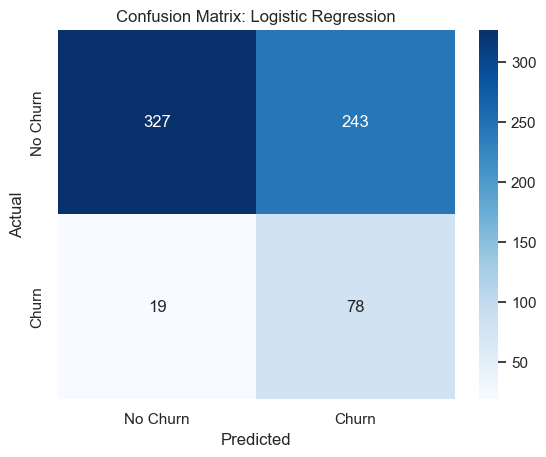

In [50]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "Logistic Regression": LogisticRegression(C=1e3, max_iter=10000, class_weight='balanced',  random_state=42)}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Logistic Regression
    Best Parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
    Test Accuracy: 0.850 | Precision: 0.435 | Recall: 0.103 | F1-Score: 0.167


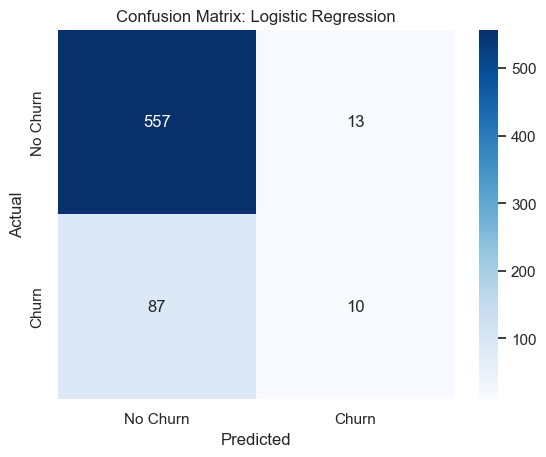

In [51]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "Logistic Regression": LogisticRegression(C=1e3, max_iter=10000, random_state=42)}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training Logistic Regression
    Best Parameters: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    Test Accuracy: 0.846 | Precision: 0.435 | Recall: 0.206 | F1-Score: 0.280


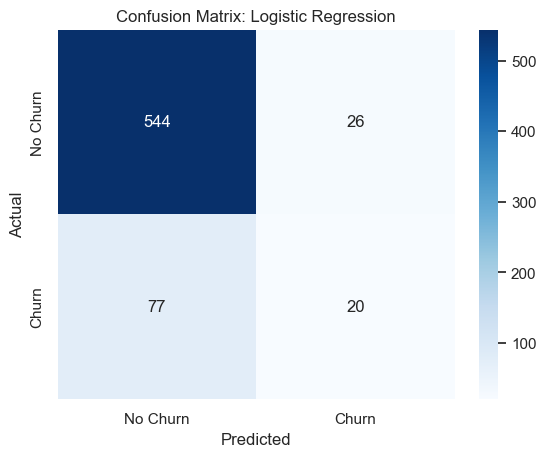

In [52]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "Logistic Regression": LogisticRegression(C=1e3, max_iter=10000, random_state=42)}
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

In [4]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Logistic Regression
first_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(),
}

#The metrics to search in our grid search.
first_model_param_grid = {
   "K-Neighbors": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]}
}
first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)

NameError: name 'new_function' is not defined


Training K-Neighbors
    Best Parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weights': 'distance'}
    Test Accuracy: 0.807 | Precision: 0.289 | Recall: 0.227 | F1-Score: 0.254


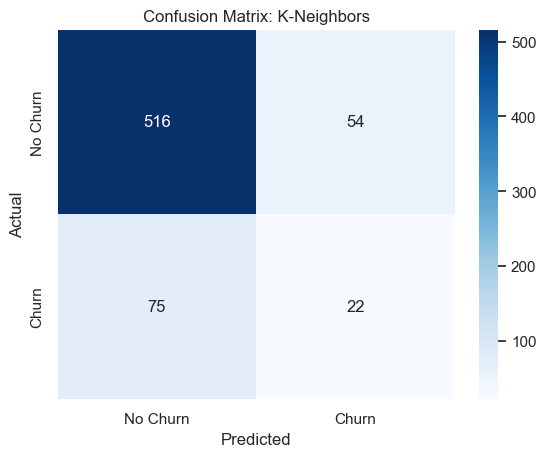

In [54]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=3)
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training K-Neighbors
    Best Parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weights': 'distance'}
    Test Accuracy: 0.859 | Precision: 0.522 | Recall: 0.361 | F1-Score: 0.427


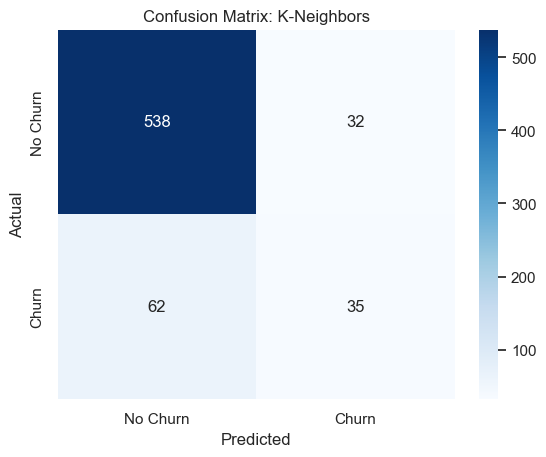

In [55]:
third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=3)
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training K-Neighbors
    Best Parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
    Test Accuracy: 0.894 | Precision: 0.703 | Recall: 0.464 | F1-Score: 0.559


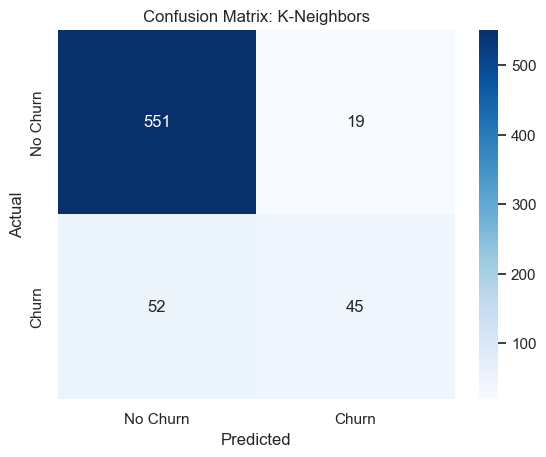

In [56]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=3)}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training K-Neighbors
    Best Parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'distance'}
    Test Accuracy: 0.892 | Precision: 0.654 | Recall: 0.546 | F1-Score: 0.596


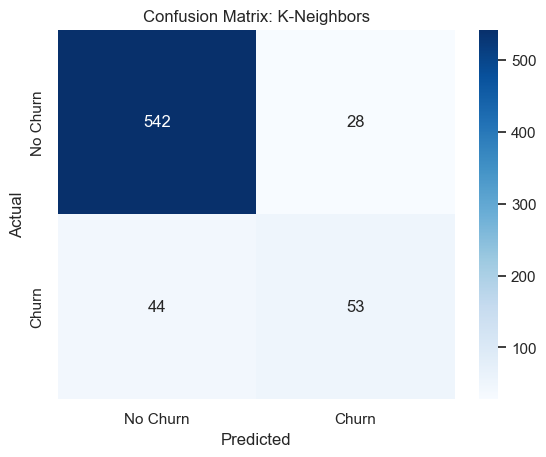

In [57]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=3)}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training K-Neighbors
    Best Parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
    Test Accuracy: 0.877 | Precision: 0.623 | Recall: 0.392 | F1-Score: 0.481


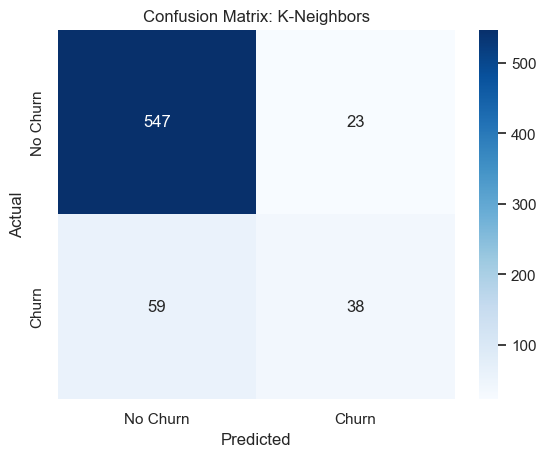

In [58]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "K-Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=7)}
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

### GaussianNB


Training GaussianNB
    Cross-Validation Score: 0.000 ± 0.000
    Test Accuracy: 0.855 | Precision: 0.000 | Recall: 0.000 | F1-Score: 0.000


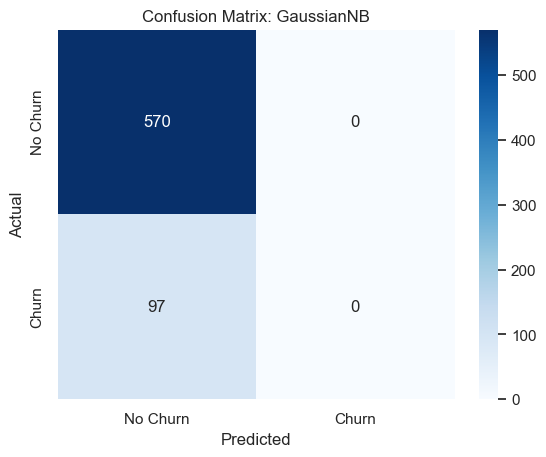

In [59]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Logistic Regression
first_model_to_test = {
    "GaussianNB": GaussianNB(),
}

#The metrics to search in our grid search.
first_model_param_grid = {
  "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100, 1000],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__solver": ["liblinear", "saga"]}
}

first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)


Training GaussianNB
    Cross-Validation Score: 0.054 ± 0.021
    Test Accuracy: 0.859 | Precision: 0.636 | Recall: 0.072 | F1-Score: 0.130


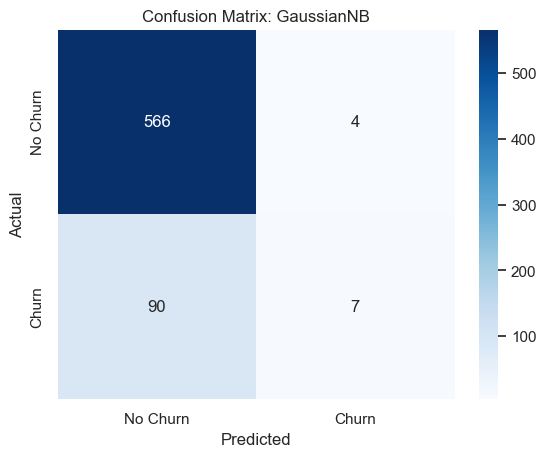

In [60]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "GaussianNB": GaussianNB(),
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training GaussianNB
    Cross-Validation Score: 0.277 ± 0.033
    Test Accuracy: 0.877 | Precision: 0.674 | Recall: 0.299 | F1-Score: 0.414


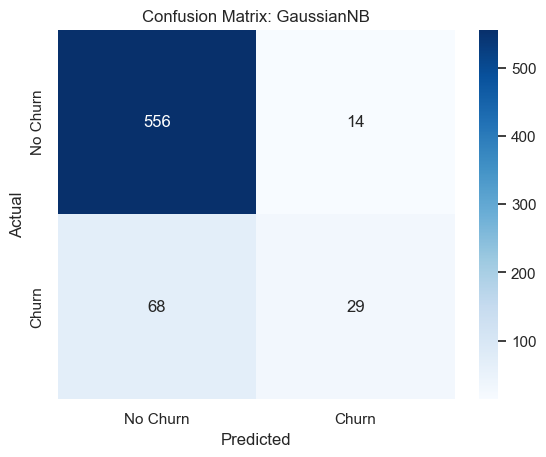

In [61]:
#let's add another feature, and continue to tweak the hyperparameters changing min_samples_leaf=5... 

third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "GaussianNB": GaussianNB(),
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training GaussianNB
    Cross-Validation Score: 0.383 ± 0.045
    Test Accuracy: 0.861 | Precision: 0.536 | Recall: 0.309 | F1-Score: 0.392


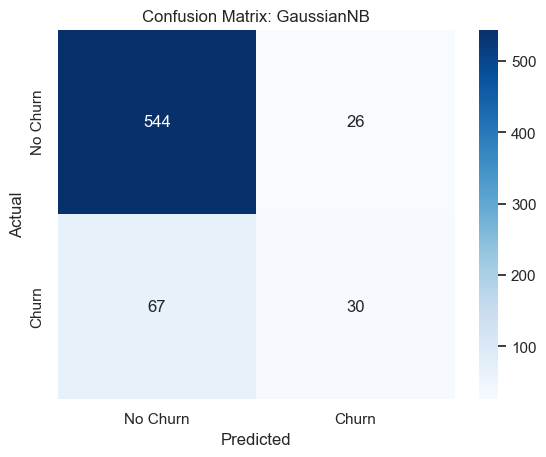

In [62]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "GaussianNB": GaussianNB()}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training GaussianNB
    Cross-Validation Score: 0.472 ± 0.073
    Test Accuracy: 0.843 | Precision: 0.462 | Recall: 0.495 | F1-Score: 0.478


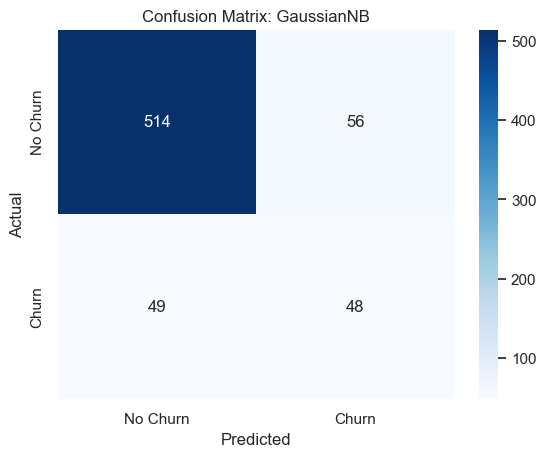

In [63]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "GaussianNB": GaussianNB()}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training GaussianNB
    Cross-Validation Score: 0.694 ± 0.086
    Test Accuracy: 0.547 | Precision: 0.188 | Recall: 0.639 | F1-Score: 0.291


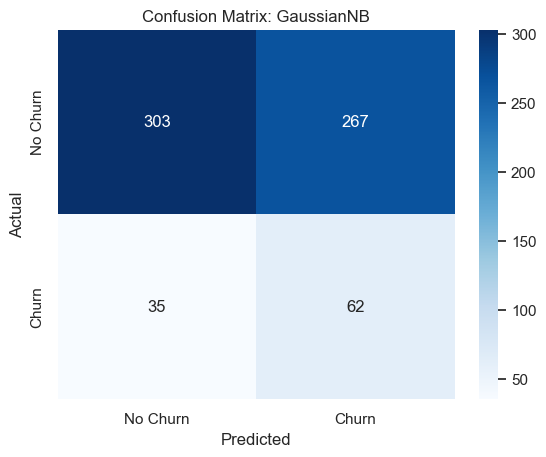

In [64]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "GaussianNB": GaussianNB()}
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

# XGBoost Random Forest


Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 50, 'model__subsample': 1.0}
    Test Accuracy: 0.754 | Precision: 0.132 | Recall: 0.124 | F1-Score: 0.128


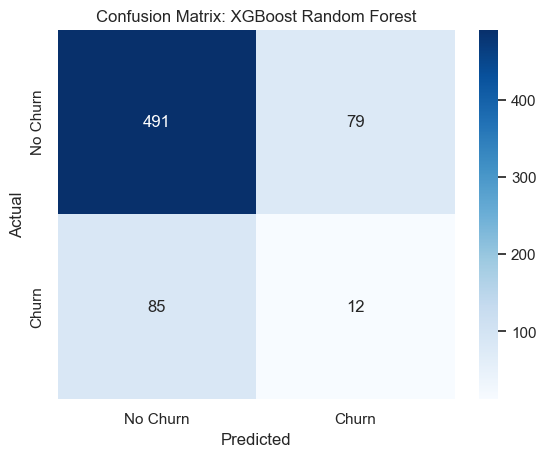

In [65]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Logistic Regression
first_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))  # Adjust class imbalance
}

#The metrics to search in our grid search.
first_model_param_grid = {
 "XGBoost Random Forest": {
        "model__n_estimators": [50, 100, 200],  
        "model__max_depth": [3, 5, 10],         
        "model__learning_rate": [0.01, 0.1, 0.2], 
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]}
 }
first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)


Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
    Test Accuracy: 0.832 | Precision: 0.431 | Recall: 0.485 | F1-Score: 0.456


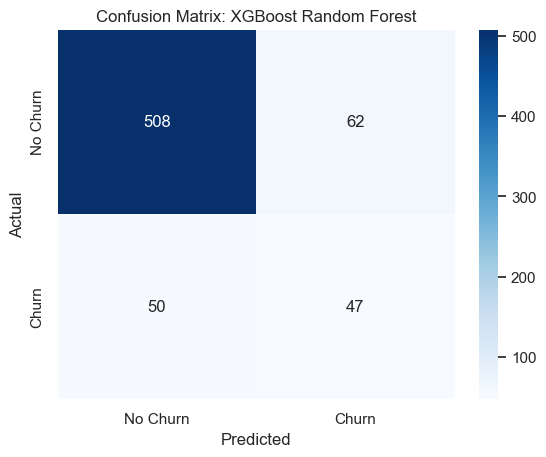

In [66]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))  # Adjust class imbalance
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__subsample': 0.8}
    Test Accuracy: 0.892 | Precision: 0.676 | Recall: 0.495 | F1-Score: 0.571


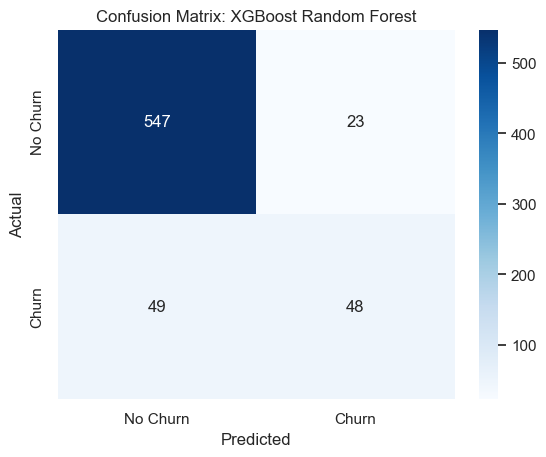

In [67]:
#let's add another feature, and continue to tweak the hyperparameters changing min_samples_leaf=5... 

third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))  # Adjust class imbalance
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
    Test Accuracy: 0.925 | Precision: 0.790 | Recall: 0.660 | F1-Score: 0.719


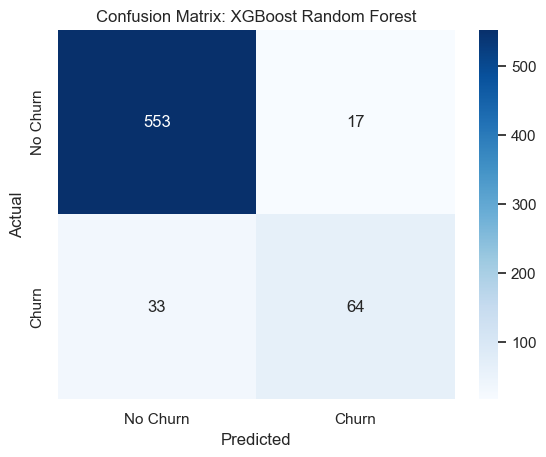

In [68]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))}  
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468



Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}
    Test Accuracy: 0.900 | Precision: 0.612 | Recall: 0.845 | F1-Score: 0.710


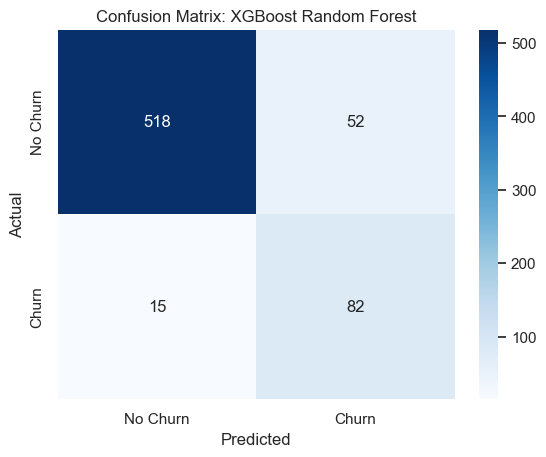

In [69]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))}  # Adjust class imbalance
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Random Forest
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 1.0}
    Test Accuracy: 0.901 | Precision: 0.617 | Recall: 0.845 | F1-Score: 0.713


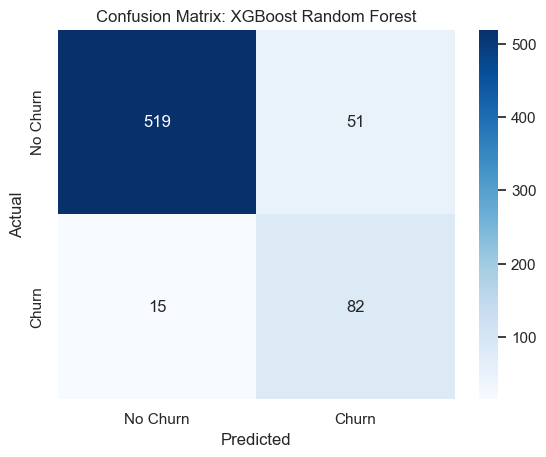

In [70]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {
    "XGBoost Random Forest": XGBRFClassifier(random_state=42, scale_pos_weight=(2800/500))}  # Adjust class imbalance
sixth_model_results = new_function(sixth_model_columns, train_df, sixth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 0.1, 'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__subsample': 0.8}
    Test Accuracy: 0.589 | Precision: 0.161 | Recall: 0.433 | F1-Score: 0.235


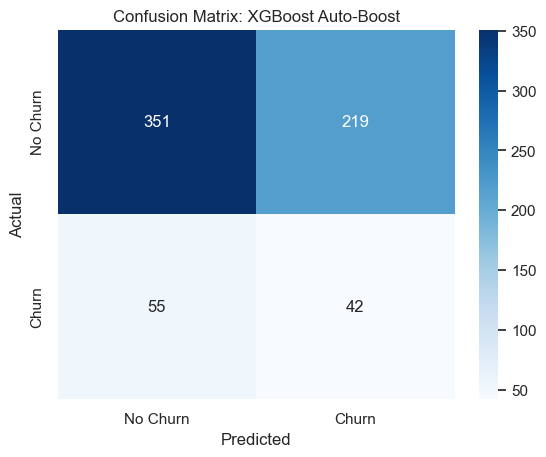

In [71]:
#startng off with just one feature and our target.
first_model_columns = ['total calls', 'churn']

#Logistic Regression
first_model_to_test = {
    "XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, verbosity=0)
}


#The metrics to search in our grid search.
first_model_param_grid = {
  "XGBoost Auto-Boost": {
        "model__n_estimators": [100, 200, 300],  # Number of boosting rounds
        "model__max_depth": [3, 5, 10],          # Max tree depth
        "model__learning_rate": [0.01, 0.1, 0.2], # Shrinks weights to prevent overfitting
        "model__gamma": [0, 0.1, 0.5],           # Minimum loss reduction required for a split
        "model__subsample": [0.8, 1.0],          # Fraction of training data per boosting round
        "model__colsample_bytree": [0.8, 1.0]}    # Fraction of features per boosting round
}

first_model_results = new_function(first_model_columns, train_df, first_model_to_test, first_model_param_grid, preprocessor)
#produces a recall score of 0.429


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
    Test Accuracy: 0.730 | Precision: 0.287 | Recall: 0.577 | F1-Score: 0.384


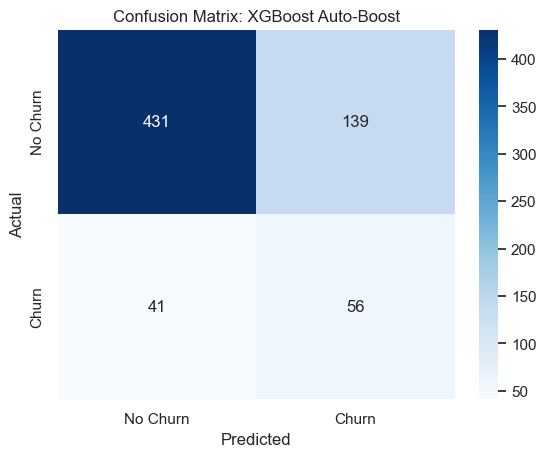

In [72]:
#Now let's add in one feature more feature, 'total minutes' and tweaking our max_depth hyperparameter to 20.

second_model_columns = ['total calls','total minutes', 'churn']

#Starting with Decision Tree and setting class_weight='balanced' to help us with our class imbalance issues.
second_model_to_test = {
    "XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, verbosity=0)
}
second_model_results = new_function(second_model_columns, train_df, second_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
    Test Accuracy: 0.822 | Precision: 0.420 | Recall: 0.598 | F1-Score: 0.494


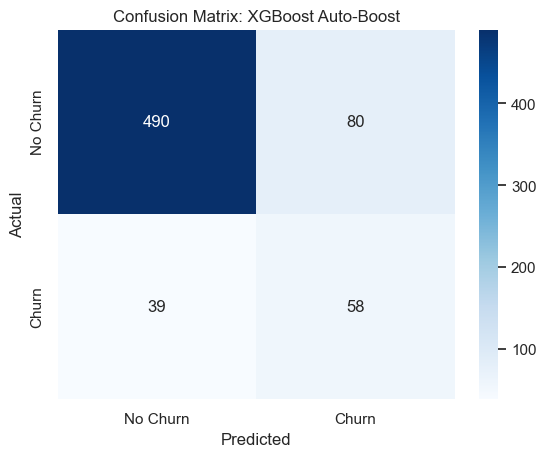

In [73]:
#let's add another feature, and continue to tweak the hyperparameters changing min_samples_leaf=5... 

third_model_columns = ['total calls','total minutes', 'total charges', 'churn']

#adjusting or min_samples_leaf=5
third_model_to_test = {
    "XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, verbosity=0)
}
third_model_results = new_function(third_model_columns, train_df, third_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
    Test Accuracy: 0.901 | Precision: 0.660 | Recall: 0.660 | F1-Score: 0.660


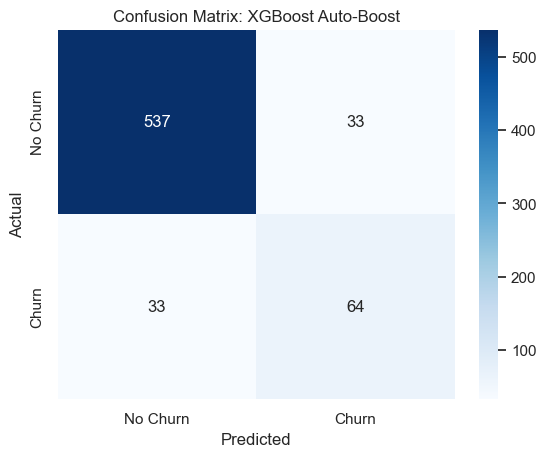

In [74]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fourth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'churn']

#adjusting or min_samples_leaf=5
fourth_model_to_test = {
    "XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, verbosity=0)}
fourth_model_results = new_function(fourth_model_columns, train_df, fourth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}
    Test Accuracy: 0.901 | Precision: 0.617 | Recall: 0.845 | F1-Score: 0.713


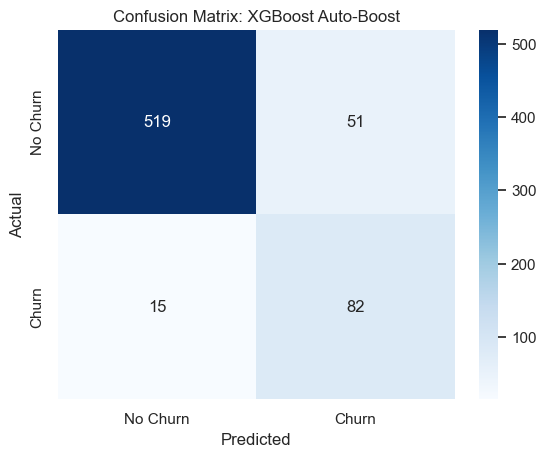

In [75]:

#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

fifth_model_columns = ['total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']

#adjusting or min_samples_leaf=5
fifth_model_to_test = {
    "XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, verbosity=0)}
fifth_model_results = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468


Training XGBoost Auto-Boost
    Best Parameters: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}
    Test Accuracy: 0.901 | Precision: 0.617 | Recall: 0.845 | F1-Score: 0.713


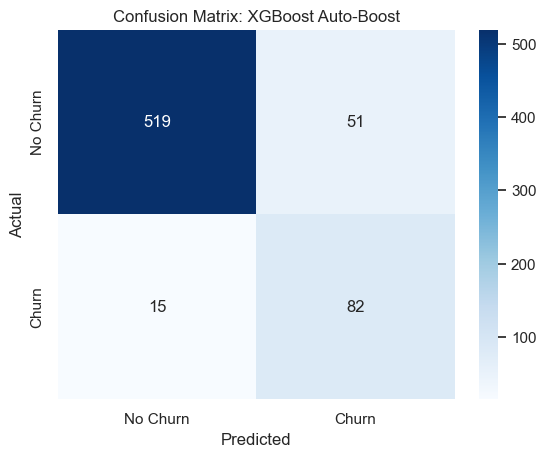

ValueError: too many values to unpack (expected 2)

In [76]:
#let's add another feature, 'customer service calls', and continue to tweak the hyperparameters, adjusting our max_depth to 10.

sixth_model_columns = ['state', 'total calls','total minutes', 'total charges', 'customer service calls', 'international plan', 'churn']
#adjusting or min_samples_leaf=5
sixth_model_to_test = {"XGBoost Auto-Boost": XGBClassifier(random_state=42, scale_pos_weight=(2800/500), use_label_encoder=False, 
verbosity=0)}

sixth_model_results, best_model = new_function(fifth_model_columns, train_df, fifth_model_to_test, first_model_param_grid, preprocessor) #Recall: 0.468

In [ ]:
models_to_test = {
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(C=1e3, max_iter=10000, random_state=42)
}

In [ ]:
param_grid = {
    "K-Neighbors": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    },
    "Decision Tree": {
        "model__max_depth": [3, 5, 10, 20, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    },
    "Random Forest": {
        "model__n_estimators": [50, 100, 200, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]},
    
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100, 1000],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__solver": ["liblinear", "saga"]}
}

In [ ]:
#
#but the best scores are:

#Best Decision Tree: Test Accuracy: 0.910 | Precision: 0.633 | Recall: 0.896 | F1-Score: 0.742

#Best random forest: Test Accuracy: 0.878 | Precision: 0.548 | Recall: 0.896 | F1-Score: 0.680

#best logistic regression: Test Accuracy: 0.620 | Precision: 0.242 | Recall: 0.766 | F1-Score: 0.368

#best kNN : Test Accuracy: 0.899 | Precision: 0.717 | Recall: 0.494 | F1-Score: 0.585

#best GaussianNB Test Accuracy: 0.547 | Precision: 0.181 | Recall: 0.610 | F1-Score: 0.280

#best XGboost Random forest: Test Accuracy: 0.910 | Precision: 0.633 | Recall: 0.896 | F1-Score: 0.742

#best XGboost Auto Boosted Tree: Test Accuracy: 0.910 | Precision: 0.633 | Recall: 0.896 | F1-Score: 0.742

In [ ]:
reference = ['https://www.kaggle.com/code/satoru90/telecom-churn-dataset-classification-with-96-acc',
             'https://www.kaggle.com/code/ambpro/dealing-with-unbalance-eda-pca-smote-lr-svm-dt-rf',
            'https://www.kaggle.com/code/visionary20/orange-telecom-prevention-and-predicting-churn',
            'https://saturncloud.io/blog/how-to-count-nan-values-in-a-pandas-dataframe-column',
            ' Cornell Paper on SMOTE https://arxiv.org/pdf/2201.08528']

In [ ]:
for site in reference:
    print(site)